In [1]:
import numpy as np
import pandas as pd
import datetime
import statsmodels as sms
import pickle
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns # for data visualization
sns.set_style("whitegrid")

from dateutil.relativedelta import *
from pandas.tseries.offsets import *

pd.set_option('display.max_columns', None)

In [2]:
#All these packages need to be installed from pip
#import gensim#For word2vec, etc
import requests #For downloading our datasets
#import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [3]:
import wrds
conn = wrds.Connection(wrds_username='dachxiu')

Enter your WRDS username [dachxiu]:
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [4]:
conn.describe_table(library="ibes", table="det_epsus")

Approximately 29748352 rows in ibes.det_epsus.


,name,nullable,type
0,ticker,True,VARCHAR(6)
1,cusip,True,VARCHAR(8)
2,oftic,True,VARCHAR(6)
3,cname,True,VARCHAR(16)
4,actdats,True,DATE
5,estimator,True,DOUBLE PRECISION
6,analys,True,DOUBLE PRECISION
7,currfl,True,VARCHAR(1)
8,pdf,True,VARCHAR(1)
9,fpi,True,VARCHAR(1)


In [5]:
# get identifier of companies from query result
df_residuals = pd.read_csv("residuals.csv")
df_residuals = df_residuals.rename(columns={'TICKER_x':'ticker'}).drop(columns=["Unnamed: 0", "TICKER_y"])
df_residuals['date'] = pd.to_datetime(df_residuals['date'].astype(str), format='%Y%m%d').dt.strftime("%Y-%m-%d")
tic_list = tuple(np.unique(df_residuals['ticker'].tolist()))
start_date, end_date = df_residuals["date"].iloc[[0,-1]].astype(str)

In [6]:
df_residuals

,date,PERMNO,ticker,RET,Residual
0,2003-01-02,10078,SUNW,0.086817,0.038124
1,2003-01-02,10104,ORCL,0.037963,-0.011596
2,2003-01-02,10107,MSFT,0.039072,-0.001425
3,2003-01-02,10108,SDS,0.035654,-0.004675
4,2003-01-02,10137,AYE,0.031746,0.011199
...,...,...,...,...,...
2238663,2020-08-31,93002,AVGO,0.006757,0.011174
2238664,2020-08-31,93089,VRSK,-0.003630,-0.000056
2238665,2020-08-31,93096,DG,0.007436,0.008512
2238666,2020-08-31,93132,FTNT,0.009676,0.011805


In [7]:
df_residuals.drop_duplicates(subset=['date', 'PERMNO', 'ticker'], inplace=True)

In [8]:
parm_new = {'identifier': tic_list, 'start_date' : start_date}
forecast_df = conn.raw_sql(f"""
                             select cusip, ticker, analys, estimator, value, measure, anndats, actdats, anndats_act, fpedats, actual, fpi from ibes.det_epsus
                             where ticker in %(identifier)s and anndats >= %(start_date)s
                            """,
                       params=parm_new)

Estimator: Sell-side institution or contributor. In the past, I/B/E/S uses 'Broker'.

Analyst: Person at the sell-side institution or contributing analyst who makes the forecast.

Measure: A prediction from the analyst about future earnings or another measure for a specific issue/entity and time period.

Announce date(ANNDATS) is the date that the forecast/actual was reported.

Activation date(ACTDATS) is the date that the forecast/actual was recorded by Thomson Reuters.

Forecast Period End Date (FPEDATS) is the date to which the estimate applies. For 70% of the companies, an estimate for a particular fiscal year will have an FPEDATS of December 31st of that year.

The FPI (forecast period indicator)

Because not all companies have the same fiscal year end, Thomson Reuters uses FPI(a numeric value or one-character code) to identify estimates for each unique period. Using the reported periods as a base, the period end dates for all estimated periods are easily calculated. For example, if December 2007 is the last reported annual(assume the calendar year = the fiscal year), the FPI=1, FPI=2 and FPI=3 estimates are for the periods ending December 2008, 2009 and 2010, respectively. Please note FPI=0 is for long term growth.

In [9]:
forecast_df

,cusip,ticker,analys,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi
0,01381710,AA,662.0,183.0,11.00,EPS,2003-01-09,2003-01-10,None,None,NaN,0
1,01381710,AA,662.0,183.0,1.10,EPS,2003-01-22,2003-01-23,None,None,NaN,0
2,01381710,AA,662.0,183.0,11.00,EPS,2003-01-24,2003-01-24,None,None,NaN,0
3,01381710,AA,662.0,183.0,10.00,EPS,2003-01-27,2003-01-28,None,None,NaN,0
4,01381710,AA,49831.0,249.0,7.00,EPS,2003-02-05,2003-02-07,None,None,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5057133,98956P10,ZMH,135724.0,3477.0,11.04,EPS,2021-11-05,2021-11-05,None,2025-12-31,NaN,5
5057134,98956P10,ZMH,1755.0,260.0,10.19,EPS,2021-11-04,2021-11-06,None,2025-12-31,NaN,5
5057135,98956P10,ZMH,119817.0,930.0,10.55,EPS,2021-11-04,2021-11-06,None,2025-12-31,NaN,5
5057136,98956P10,ZMH,71004.0,4201.0,10.02,EPS,2021-12-06,2021-12-07,None,2025-12-31,NaN,5


In [10]:
forecast_df.isna().sum()

cusip            1380
ticker              0
analys              0
estimator           0
value               0
measure             0
anndats             0
actdats             0
anndats_act    601847
fpedats         97115
actual         604439
fpi                 0
dtype: int64

In [11]:
forecast_df.dropna(inplace=True)
forecast_df
# we can also focus on data from 2015 to 2020
# forecast_df[forecast_df['anndats']>datetime.date(2015, 1, 1)]

,cusip,ticker,analys,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi
233,01381710,AA,2894.0,1267.0,3.210,EPS,2003-01-07,2003-01-07,2003-01-08,2002-12-31,2.76,1
234,01381710,AA,20310.0,42.0,3.000,EPS,2003-01-07,2003-01-07,2003-01-08,2002-12-31,2.76,1
235,01381710,AA,20310.0,42.0,0.750,EPS,2003-01-07,2003-01-07,2003-01-08,2002-12-31,0.48,6
236,01381710,AA,662.0,183.0,0.750,EPS,2003-01-08,2003-01-10,2003-04-04,2003-03-31,0.69,6
237,01381710,AA,40316.0,308.0,0.750,EPS,2003-01-08,2003-01-10,2003-04-04,2003-03-31,0.69,6
...,...,...,...,...,...,...,...,...,...,...,...,...
5055800,98956P10,ZMH,191742.0,157.0,1.750,EPS,2020-05-07,2020-05-07,2021-11-04,2021-09-30,1.81,P
5055801,98956P10,ZMH,138585.0,220.0,2.050,EPS,2019-11-05,2019-11-05,2021-11-04,2021-09-30,1.81,Q
5055802,98956P10,ZMH,112749.0,464.0,1.974,EPS,2019-11-05,2019-11-05,2021-11-04,2021-09-30,1.81,Q
5055803,98956P10,ZMH,191742.0,157.0,2.000,EPS,2019-11-06,2019-11-06,2021-11-04,2021-09-30,1.81,Q


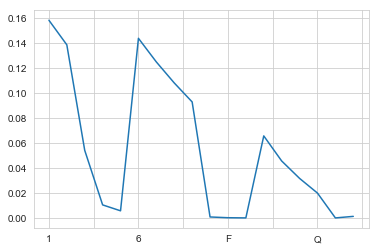

In [12]:
fpi_count = forecast_df['fpi'].value_counts().sort_index()
(fpi_count/sum(fpi_count)).plot()

In [13]:
fpi_count

1    703347
2    615877
3    240411
4     46366
5     25309
6    639052
7    554941
8    480240
9    412691
E      3379
F       734
G        91
N    291810
O    202652
P    140654
Q     88400
X        30
Y      5501
Name: fpi, dtype: int64

In [14]:
forecast_df[forecast_df['analys']==49831.0]

,cusip,ticker,analys,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi
241,01381710,AA,49831.0,249.0,0.63,EPS,2003-01-09,2003-01-13,2003-04-04,2003-03-31,0.69,6
256,01381710,AA,49831.0,249.0,0.66,EPS,2003-03-18,2003-03-18,2003-04-04,2003-03-31,0.69,6
271,01381710,AA,49831.0,249.0,0.84,EPS,2003-04-07,2003-04-07,2003-07-08,2003-06-30,0.81,6
279,01381710,AA,49831.0,249.0,0.72,EPS,2003-06-24,2003-06-24,2003-07-08,2003-06-30,0.81,6
285,01381710,AA,49831.0,249.0,0.72,EPS,2003-01-09,2003-01-13,2003-07-08,2003-06-30,0.81,7
...,...,...,...,...,...,...,...,...,...,...,...,...
953954,18683K10,CLF,49831.0,446.0,0.81,EPS,2013-02-13,2013-02-14,2013-07-25,2013-06-30,1.14,7
954153,18683K10,CLF,49831.0,446.0,0.79,EPS,2013-02-13,2013-02-14,2013-10-24,2013-09-30,0.66,8
954288,18683K10,CLF,49831.0,446.0,2.57,EPS,2013-02-13,2013-02-14,2014-02-13,2013-12-31,2.37,1
954812,18683K10,CLF,49831.0,446.0,0.88,EPS,2013-02-13,2013-02-14,2014-02-13,2013-12-31,0.20,9


In [15]:
df_sort = forecast_df.set_index(['ticker','analys'])
df_sort

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     2894.0    01381710     1267.0  3.210     EPS  2003-01-07  2003-01-07   
       20310.0   01381710       42.0  3.000     EPS  2003-01-07  2003-01-07   
       20310.0   01381710       42.0  0.750     EPS  2003-01-07  2003-01-07   
       662.0     01381710      183.0  0.750     EPS  2003-01-08  2003-01-10   
       40316.0   01381710      308.0  0.750     EPS  2003-01-08  2003-01-10   
...                   ...        ...    ...     ...         ...         ...   
ZMH    191742.0  98956P10      157.0  1.750     EPS  2020-05-07  2020-05-07   
       138585.0  98956P10      220.0  2.050     EPS  2019-11-05  2019-11-05   
       112749.0  98956P10      464.0  1.974     EPS  2019-11-05  2019-11-05   
       191742.0  98956P10      157.0  2.000     EPS  2019-11-06  2019-11-06   
       191742.0  98956P10      157.0  2.010     EPS  2020-01-23  2020-01-23   

                anndats_act     fpedats  actual fpi  
ticker analys                                        
AA     2894.0    2003-01-08  2002-12-31    2.76   1  
       20310.0   2003-01-08  2002-12-31    2.76   1  
       20310.0   2003-01-08  2002-12-31    0.48   6  
       662.0     2003-04-04  2003-03-31    0.69   6  
       40316.0   2003-04-04  2003-03-31    0.69   6  
...                     ...         ...     ...  ..  
ZMH    191742.0  2021-11-04  2021-09-30    1.81   P  
       138585.0  2021-11-04  2021-09-30    1.81   Q  
       112749.0  2021-11-04  2021-09-30    1.81   Q  
       191742.0  2021-11-04  2021-09-30    1.81   Q  
       191742.0  2021-11-04  2021-09-30    1.81   Q  

[4451485 rows x 10 columns]

In [16]:
# focus only on fpedats within one year
df_short = df_sort[df_sort['fpedats'] - df_sort['anndats'] < datetime.timedelta(365)]
df_short = df_short[df_short['fpedats'] - df_short['anndats'] > datetime.timedelta(0)]
df_short

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     662.0     01381710      183.0   0.75     EPS  2003-01-08  2003-01-10   
       40316.0   01381710      308.0   0.75     EPS  2003-01-08  2003-01-10   
       2894.0    01381710     1267.0   0.87     EPS  2003-01-09  2003-01-10   
       473.0     01381710      192.0   0.63     EPS  2003-01-08  2003-01-13   
       52285.0   01381710      118.0   0.69     EPS  2003-01-08  2003-01-13   
...                   ...        ...    ...     ...         ...         ...   
ZMH    112749.0  98956P10      464.0   1.79     EPS  2020-10-06  2020-10-06   
       5116.0    98956P10      228.0   1.80     EPS  2020-10-12  2020-10-15   
       71004.0   98956P10     2342.0   2.05     EPS  2020-10-20  2020-10-20   
       191742.0  98956P10      157.0   1.89     EPS  2020-10-21  2020-10-21   
       188894.0  98956P10     3364.0   1.84     EPS  2020-10-12  2020-10-26   

                anndats_act     fpedats  actual fpi  
ticker analys                                        
AA     662.0     2003-04-04  2003-03-31    0.69   6  
       40316.0   2003-04-04  2003-03-31    0.69   6  
       2894.0    2003-04-04  2003-03-31    0.69   6  
       473.0     2003-04-04  2003-03-31    0.69   6  
       52285.0   2003-04-04  2003-03-31    0.69   6  
...                     ...         ...     ...  ..  
ZMH    112749.0  2021-11-04  2021-09-30    1.81   N  
       5116.0    2021-11-04  2021-09-30    1.81   N  
       71004.0   2021-11-04  2021-09-30    1.81   N  
       191742.0  2021-11-04  2021-09-30    1.81   N  
       188894.0  2021-11-04  2021-09-30    1.81   N  

[2719299 rows x 10 columns]

In [17]:
df_short[df_short['anndats']>datetime.date(2015, 1, 1)]

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     73867.0   01381710      157.0   0.93     EPS  2015-01-12  2015-01-12   
       84007.0   01381710      206.0   0.84     EPS  2015-01-12  2015-01-13   
       109116.0  01381710      183.0   0.93     EPS  2015-01-12  2015-01-13   
       119644.0  01381710      192.0   0.84     EPS  2015-01-12  2015-01-13   
       73367.0   01381710     1267.0   0.81     EPS  2015-01-13  2015-01-13   
...                   ...        ...    ...     ...         ...         ...   
ZMH    112749.0  98956P10      464.0   1.79     EPS  2020-10-06  2020-10-06   
       5116.0    98956P10      228.0   1.80     EPS  2020-10-12  2020-10-15   
       71004.0   98956P10     2342.0   2.05     EPS  2020-10-20  2020-10-20   
       191742.0  98956P10      157.0   1.89     EPS  2020-10-21  2020-10-21   
       188894.0  98956P10     3364.0   1.84     EPS  2020-10-12  2020-10-26   

                anndats_act     fpedats  actual fpi  
ticker analys                                        
AA     73867.0   2015-04-08  2015-03-31    0.84   6  
       84007.0   2015-04-08  2015-03-31    0.84   6  
       109116.0  2015-04-08  2015-03-31    0.84   6  
       119644.0  2015-04-08  2015-03-31    0.84   6  
       73367.0   2015-04-08  2015-03-31    0.84   6  
...                     ...         ...     ...  ..  
ZMH    112749.0  2021-11-04  2021-09-30    1.81   N  
       5116.0    2021-11-04  2021-09-30    1.81   N  
       71004.0   2021-11-04  2021-09-30    1.81   N  
       191742.0  2021-11-04  2021-09-30    1.81   N  
       188894.0  2021-11-04  2021-09-30    1.81   N  

[993313 rows x 10 columns]

### calculate analyst forecast revision - focus only on forecast period end dates being December 31

In [18]:
def func1(data):
    return(int(x.month==12) for x in data)
df_short['year_end'] = (df_short.groupby(level=[0,1])['fpedats'].transform(func1))

In [19]:
df_short1 = df_short
df_short1

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     662.0     01381710      183.0   0.75     EPS  2003-01-08  2003-01-10   
       40316.0   01381710      308.0   0.75     EPS  2003-01-08  2003-01-10   
       2894.0    01381710     1267.0   0.87     EPS  2003-01-09  2003-01-10   
       473.0     01381710      192.0   0.63     EPS  2003-01-08  2003-01-13   
       52285.0   01381710      118.0   0.69     EPS  2003-01-08  2003-01-13   
...                   ...        ...    ...     ...         ...         ...   
ZMH    112749.0  98956P10      464.0   1.79     EPS  2020-10-06  2020-10-06   
       5116.0    98956P10      228.0   1.80     EPS  2020-10-12  2020-10-15   
       71004.0   98956P10     2342.0   2.05     EPS  2020-10-20  2020-10-20   
       191742.0  98956P10      157.0   1.89     EPS  2020-10-21  2020-10-21   
       188894.0  98956P10     3364.0   1.84     EPS  2020-10-12  2020-10-26   

                anndats_act     fpedats  actual fpi  year_end  
ticker analys                                                  
AA     662.0     2003-04-04  2003-03-31    0.69   6         0  
       40316.0   2003-04-04  2003-03-31    0.69   6         0  
       2894.0    2003-04-04  2003-03-31    0.69   6         0  
       473.0     2003-04-04  2003-03-31    0.69   6         0  
       52285.0   2003-04-04  2003-03-31    0.69   6         0  
...                     ...         ...     ...  ..       ...  
ZMH    112749.0  2021-11-04  2021-09-30    1.81   N         0  
       5116.0    2021-11-04  2021-09-30    1.81   N         0  
       71004.0   2021-11-04  2021-09-30    1.81   N         0  
       191742.0  2021-11-04  2021-09-30    1.81   N         0  
       188894.0  2021-11-04  2021-09-30    1.81   N         0  

[2719299 rows x 11 columns]

In [50]:
df_short = df_short[df_short['year_end']==1]
df_short.reset_index(inplace=True)
#df_short.set_index(['ticker','analys','fpedats'], inplace=True)
df_short.sort_values(by=['ticker','analys','fpedats','anndats'],inplace=True)

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [51]:
# keep only the first data of two identical rows
df_short = df_short.groupby(by=['ticker','analys']).apply(lambda x: x.drop_duplicates(subset=['anndats', 'anndats_act'], keep='first'))
df_short = df_short.droplevel(level=2)

In [52]:
df_short = df_short.drop(columns=['ticker', 'analys'])

In [53]:
# calculate analyst forecast revisions
df_short['forecast_revision'] = df_short.groupby(['fpedats'])['value'].transform(lambda x: x.diff())
df_short

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     473.0     01381710      192.0   3.00     EPS  2003-01-08  2003-01-13   
       476.0     01381710     2383.0   3.24     EPS  2003-10-08  2003-10-08   
       476.0     01381710     2383.0   3.36     EPS  2003-11-20  2003-11-20   
       476.0     01381710     2383.0   4.83     EPS  2004-01-09  2004-01-09   
       476.0     01381710     2383.0   5.85     EPS  2004-03-31  2004-04-01   
...                   ...        ...    ...     ...         ...         ...   
ZMH    191742.0  98956P10      157.0   4.51     EPS  2020-05-11  2020-05-18   
       191742.0  98956P10      157.0   4.45     EPS  2020-07-21  2020-07-21   
       191742.0  98956P10      157.0   5.00     EPS  2020-08-05  2020-08-17   
       191742.0  98956P10      157.0   5.05     EPS  2020-10-21  2020-10-21   
       191742.0  98956P10      157.0   5.57     EPS  2020-11-09  2020-11-09   

                anndats_act     fpedats  actual fpi  year_end  \
ticker analys                                                   
AA     473.0     2004-01-08  2003-12-31    3.30   1         1   
       476.0     2004-01-08  2003-12-31    3.30   1         1   
       476.0     2004-01-08  2003-12-31    3.30   1         1   
       476.0     2005-01-10  2004-12-31    4.68   1         1   
       476.0     2005-01-10  2004-12-31    4.68   1         1   
...                     ...         ...     ...  ..       ...   
ZMH    191742.0  2021-02-05  2020-12-31    5.67   1         1   
       191742.0  2021-02-05  2020-12-31    5.67   1         1   
       191742.0  2021-02-05  2020-12-31    5.67   1         1   
       191742.0  2021-02-05  2020-12-31    5.67   1         1   
       191742.0  2021-02-05  2020-12-31    5.67   1         1   

                 forecast_revision  
ticker analys                       
AA     473.0                   NaN  
       476.0                  0.24  
       476.0                  0.12  
       476.0                   NaN  
       476.0                  1.02  
...                            ...  
ZMH    191742.0               0.31  
       191742.0              -0.06  
       191742.0               0.55  
       191742.0               0.05  
       191742.0               0.52  

[615618 rows x 12 columns]

In [253]:
df_short.to_pickle('revisions.pkl')

In [54]:
# summary of upward&downward revision
upward_ar = df_short.loc[df_short['forecast_revision'] > 0,'value'].count()
downward_ar = df_short.loc[df_short['forecast_revision'] < 0,'value'].count()
print(f'ratio of upward revision is {upward_ar/(upward_ar+downward_ar)}')

ratio of upward revision is 0.5059854579182569


### Let's now focus only on data within 2017:

In [224]:
df_short['year']=[x.year for x in df_short['anndats']]
df_2017 = df_short[df_short['year']==2017]
df_2017

cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                 
AA     31736.0   03965L10       11.0  1.170     EPS  2017-04-27  2017-04-27   
       31736.0   03965L10       11.0  1.190     EPS  2017-08-04  2017-08-04   
       31736.0   03965L10       11.0  1.170     EPS  2017-10-26  2017-10-26   
       73867.0   03965L10      157.0  0.820     EPS  2017-01-19  2017-01-19   
       73867.0   03965L10      157.0  0.970     EPS  2017-02-01  2017-02-01   
...                   ...        ...    ...     ...         ...         ...   
ZMH    184717.0  98956P10       31.0  8.550     EPS  2017-01-31  2017-02-01   
       184717.0  98956P10       31.0  2.410     EPS  2017-04-27  2017-04-27   
       184717.0  98956P10       31.0  8.200     EPS  2017-07-27  2017-07-27   
       184717.0  98956P10       31.0  8.035     EPS  2017-11-01  2017-11-01   
       184717.0  98956P10       31.0  8.035     EPS  2017-12-19  2017-12-19   

                anndats_act     fpedats  actual fpi  year_end  \
ticker analys                                                   
AA     31736.0   2018-02-05  2017-12-31    1.22   1         1   
       31736.0   2018-02-05  2017-12-31    1.22   1         1   
       31736.0   2018-02-05  2017-12-31    1.22   1         1   
       73867.0   2018-02-05  2017-12-31    1.22   2         1   
       73867.0   2018-02-05  2017-12-31    1.22   1         1   
...                     ...         ...     ...  ..       ...   
ZMH    184717.0  2018-01-30  2017-12-31    8.03   1         1   
       184717.0  2018-01-30  2017-12-31    2.10   8         1   
       184717.0  2018-01-30  2017-12-31    8.03   1         1   
       184717.0  2018-01-30  2017-12-31    8.03   1         1   
       184717.0  2018-01-30  2017-12-31    8.03   1         1   

                 forecast_revision  year  
ticker analys                             
AA     31736.0                 NaN  2017  
       31736.0               0.020  2017  
       31736.0              -0.020  2017  
       73867.0              -0.350  2017  
       73867.0               0.150  2017  
...                            ...   ...  
ZMH    184717.0             -0.200  2017  
       184717.0             -6.140  2017  
       184717.0              5.790  2017  
       184717.0             -0.165  2017  
       184717.0              0.000  2017  

[35001 rows x 13 columns]

In [56]:
df_anndats = df_2017.anndats.to_frame()
df_anndats

anndats
ticker analys              
AA     31736.0   2017-04-27
       31736.0   2017-08-04
       31736.0   2017-10-26
       73867.0   2017-01-19
       73867.0   2017-02-01
...                     ...
ZMH    184717.0  2017-01-31
       184717.0  2017-04-27
       184717.0  2017-07-27
       184717.0  2017-11-01
       184717.0  2017-12-19

[35001 rows x 1 columns]

In [106]:
# set target days - one day before the ann_dates
dates_2017 = { date : (date - datetime.timedelta(days=1)) for date in list(df_anndats.values.flatten())}

### obtain text data for relevant dates

In [107]:
import os
text_data_2017 = pd.DataFrame()
directory_in_str = '/Users/chentian/Desktop/RAdata/text_data'
format='%Y%m%d'
directory = os.fsencode(directory_in_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        file_path = os.path.join(directory_in_str, filename)
        data1 = pd.read_pickle(file_path)
        # convert from string format to datetime format
        data1['Date']=data1['Date'].apply(lambda x: datetime.datetime.strptime(x, format).date())
        #data1['Date'] = pd.to_datetime(data1['Date'], format='%Y%m%d')
        #data1.set_index(['Date'],inplace=True)
        for key, value in dates_2017.items():
            data2 = data1[data1['Date']==value]
            data2['anndats'] = key
            text_data_2017 = pd.concat([text_data_2017,data2])
            #text_data_2017 = pd.concat([text_data_2017,data1[data1.Date.isin(dates_dic.values)]])
        
text_data_2017.sort_values(by=['Date'],inplace=True)
text_data_2017.reset_index(drop=True,inplace=True)

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [110]:
text_data_2017 = text_data_2017.set_index(['anndats', 'Date'])

In [214]:
text_data_2017

Company  \
anndats    Date                                                           
2017-01-02 2017-01-01                                              None   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01                                              None   
...                                                                 ...   
2017-12-29 2017-12-28                                              None   
           2017-12-28                                   \nGOOG\nGOOGL\n   
           2017-12-28                                              None   
           2017-12-28                                           \nSNV\n   
           2017-12-28                                          \nCBMG\n   

                                                                   Title  \
anndats    Date                                                            
2017-01-02 2017-01-01  \nInterbank Foreign Exchange Rates At 23:50 ES...   
           2017-01-01     \nFrench New Car Registrations Up 5.1% in 2016   
           2017-01-01  \nRenault New Car Registrations in France Up 0...   
           2017-01-01  \nPeugeot New Car Registrations in France Down...   
           2017-01-01  \nTurkish Authorities Hunt for Gunman in Istan...   
...                                                                  ...   
2017-12-29 2017-12-28  \nUS Chicago Purch Mgmt Adj Dec Index +67.6 vs...   
           2017-12-28       \nVP Campbell Surrenders 201 Of Alphabet Inc   
           2017-12-28             \nZumbrota Hog/Sheep Market For Dec 27   
           2017-12-28  \nVP Copeland Gifts 3,100 Of Synovus Financial...   
           2017-12-28  \nPress Release: Cellular Biomedicine Group An...   

                                                                 Article  \
anndats    Date                                                            
2017-01-02 2017-01-01  \n\n \n                           Latest      ...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\nBy Margaret Coker and Emre Peker \n\n     ...   
...                                                                  ...   
2017-12-29 2017-12-28  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Alphabet In...   
           2017-12-28  \n\nSource: Central Livestock Association \n \...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Synovus Fin...   
           2017-12-28  \n\n  Cellular Biomedicine Group Announces Clo...   

                            System_GMT_Time  \
anndats    Date                               
2017-01-02 2017-01-01  20170102T045016.304Z   
           2017-01-01  20170101T131603.377Z   
           2017-01-01  20170101T131607.523Z   
           2017-01-01  20170101T131611.602Z   
           2017-01-01  20170101T132903.071Z   
...                                     ...   
2017-12-29 2017-12-28  20171228T144546.446Z   
           2017-12-28  20171228T144556.253Z   
           2017-12-28  20171228T144709.774Z   
           2017-12-28  20171228T143246.937Z   
           2017-12-28  20171228T123003.016Z   

                                              Display_ET_Time  \
anndats    Date                                                 
2017-01-02 2017-01-01   January 01, 2017 23:50 ET (04:50 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:29 ET (13:29 GMT)   
...                                        

In [273]:
text_data_2017.drop(columns='Company')

Title  \
anndats    Date                                                            
2017-01-02 2017-01-01  \nInterbank Foreign Exchange Rates At 23:50 ES...   
           2017-01-01     \nFrench New Car Registrations Up 5.1% in 2016   
           2017-01-01  \nRenault New Car Registrations in France Up 0...   
           2017-01-01  \nPeugeot New Car Registrations in France Down...   
           2017-01-01  \nTurkish Authorities Hunt for Gunman in Istan...   
...                                                                  ...   
2017-12-29 2017-12-28  \nUS Chicago Purch Mgmt Adj Dec Index +67.6 vs...   
           2017-12-28       \nVP Campbell Surrenders 201 Of Alphabet Inc   
           2017-12-28             \nZumbrota Hog/Sheep Market For Dec 27   
           2017-12-28  \nVP Copeland Gifts 3,100 Of Synovus Financial...   
           2017-12-28  \nPress Release: Cellular Biomedicine Group An...   

                                                                 Article  \
anndats    Date                                                            
2017-01-02 2017-01-01  \n\n \n                           Latest      ...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\nBy Margaret Coker and Emre Peker \n\n     ...   
...                                                                  ...   
2017-12-29 2017-12-28  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Alphabet In...   
           2017-12-28  \n\nSource: Central Livestock Association \n \...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Synovus Fin...   
           2017-12-28  \n\n  Cellular Biomedicine Group Announces Clo...   

                            System_GMT_Time  \
anndats    Date                               
2017-01-02 2017-01-01  20170102T045016.304Z   
           2017-01-01  20170101T131603.377Z   
           2017-01-01  20170101T131607.523Z   
           2017-01-01  20170101T131611.602Z   
           2017-01-01  20170101T132903.071Z   
...                                     ...   
2017-12-29 2017-12-28  20171228T144546.446Z   
           2017-12-28  20171228T144556.253Z   
           2017-12-28  20171228T144709.774Z   
           2017-12-28  20171228T143246.937Z   
           2017-12-28  20171228T123003.016Z   

                                              Display_ET_Time  \
anndats    Date                                                 
2017-01-02 2017-01-01   January 01, 2017 23:50 ET (04:50 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:29 ET (13:29 GMT)   
...                                                       ...   
2017-12-29 2017-12-28  December 28, 2017 09:45 ET (14:45 GMT)   
           2017-12-28  December 28, 2017 09:45 ET (14:45 GMT)   
           2017-12-28  December 28, 2017 09:47 ET (14:47 GMT)   
           2017-12-28  December 28, 2017 09:32 ET (14:32 GMT)   
           2017-12-28  December 28, 2017 07:30 ET (12:30 GMT)   

                      Accession_Number  title_sent  article_sent  
anndats    Date                                                   
2017-01-02 2017-01-01   20170101001016   -0.125000      0.071229  
           2017-01-01   20170101000444    0.068182      0.500000  
           2017-01-01   20170101000444    0.136364      0.500000  
           2017-01-01   20170101000444   -0.009596      0.500000  
           2017-01-01   20170101000453    0.000000      0.009984  
...                                ...         ...           ...  
2017-12-29 2017-12-28   20171228002590    0.000000      0.500000  
           2017-12-28   2017

### Sentiment analysis for all the news before announcement days

In [113]:
text_data_2017['title_sent']=text_data_2017['Title'].transform(lambda x: TextBlob(x).sentiment.polarity)
text_data_2017['article_sent']=text_data_2017['Article'].transform(lambda x: TextBlob(x).sentiment.polarity)

In [207]:
text_data_2017.to_pickle('text_data_2017.pkl')

In [200]:
all_sent_2017 = text_data_2017.groupby(level=0)['title_sent','article_sent'].mean()
all_sent_2017

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,title_sent,article_sent
anndats,,
2017-01-02,-0.033846,0.136822
2017-01-03,0.026829,0.119778
2017-01-04,0.030563,0.137906
2017-01-05,0.028211,0.137575
2017-01-06,0.031673,0.131053
...,...,...
2017-12-22,0.017406,0.093919
2017-12-26,-0.021230,0.047126
2017-12-27,0.014222,0.083819


In [201]:
all_sent_2017.reset_index(inplace=True)
all_sent_2017['anndats']=all_sent_2017['anndats'].transform(lambda x: x.date())

In [226]:
df_2017.reset_index(inplace=True)

In [227]:
df_2017

,ticker,analys,cusip,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi,year_end,forecast_revision,year
0,AA,31736.0,03965L10,11.0,1.170,EPS,2017-04-27,2017-04-27,2018-02-05,2017-12-31,1.22,1,1,NaN,2017
1,AA,31736.0,03965L10,11.0,1.190,EPS,2017-08-04,2017-08-04,2018-02-05,2017-12-31,1.22,1,1,0.020,2017
2,AA,31736.0,03965L10,11.0,1.170,EPS,2017-10-26,2017-10-26,2018-02-05,2017-12-31,1.22,1,1,-0.020,2017
3,AA,73867.0,03965L10,157.0,0.820,EPS,2017-01-19,2017-01-19,2018-02-05,2017-12-31,1.22,2,1,-0.350,2017
4,AA,73867.0,03965L10,157.0,0.970,EPS,2017-02-01,2017-02-01,2018-02-05,2017-12-31,1.22,1,1,0.150,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34996,ZMH,184717.0,98956P10,31.0,8.550,EPS,2017-01-31,2017-02-01,2018-01-30,2017-12-31,8.03,1,1,-0.200,2017
34997,ZMH,184717.0,98956P10,31.0,2.410,EPS,2017-04-27,2017-04-27,2018-01-30,2017-12-31,2.10,8,1,-6.140,2017
34998,ZMH,184717.0,98956P10,31.0,8.200,EPS,2017-07-27,2017-07-27,2018-01-30,2017-12-31,8.03,1,1,5.790,2017
34999,ZMH,184717.0,98956P10,31.0,8.035,EPS,2017-11-01,2017-11-01,2018-01-30,2017-12-31,8.03,1,1,-0.165,2017


In [228]:
df_2017_all = df_2017.merge(all_sent_2017, how="left", on="anndats")
df_2017_all

,ticker,analys,cusip,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi,year_end,forecast_revision,year,title_sent,article_sent
0,AA,31736.0,03965L10,11.0,1.170,EPS,2017-04-27,2017-04-27,2018-02-05,2017-12-31,1.22,1,1,NaN,2017,0.041805,0.198779
1,AA,31736.0,03965L10,11.0,1.190,EPS,2017-08-04,2017-08-04,2018-02-05,2017-12-31,1.22,1,1,0.020,2017,0.014304,0.171732
2,AA,31736.0,03965L10,11.0,1.170,EPS,2017-10-26,2017-10-26,2018-02-05,2017-12-31,1.22,1,1,-0.020,2017,0.015422,0.157794
3,AA,73867.0,03965L10,157.0,0.820,EPS,2017-01-19,2017-01-19,2018-02-05,2017-12-31,1.22,2,1,-0.350,2017,0.030056,0.160466
4,AA,73867.0,03965L10,157.0,0.970,EPS,2017-02-01,2017-02-01,2018-02-05,2017-12-31,1.22,1,1,0.150,2017,0.025526,0.168463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34996,ZMH,184717.0,98956P10,31.0,8.550,EPS,2017-01-31,2017-02-01,2018-01-30,2017-12-31,8.03,1,1,-0.200,2017,0.021191,0.160785
34997,ZMH,184717.0,98956P10,31.0,2.410,EPS,2017-04-27,2017-04-27,2018-01-30,2017-12-31,2.10,8,1,-6.140,2017,0.041805,0.198779
34998,ZMH,184717.0,98956P10,31.0,8.200,EPS,2017-07-27,2017-07-27,2018-01-30,2017-12-31,8.03,1,1,5.790,2017,0.020950,0.152155
34999,ZMH,184717.0,98956P10,31.0,8.035,EPS,2017-11-01,2017-11-01,2018-01-30,2017-12-31,8.03,1,1,-0.165,2017,0.017485,0.142914


In [284]:
import statsmodels.api as sm
reg_df = df_2017_all.dropna()
y = reg_df['forecast_revision']
X_cols = ['article_sent','title_sent']
X = sm.add_constant(reg_df[X_cols])
X1 = sm.add_constant(reg_df[X_cols[0]])
X2 = sm.add_constant(reg_df[X_cols[1]])

In [285]:
lm1 = sm.OLS(y,X1).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      forecast_revision   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.701
Date:                Fri, 18 Mar 2022   Prob (F-statistic):             0.0553
Time:                        15:55:45   Log-Likelihood:                -70015.
No. Observations:               35000   AIC:                         1.400e+05
Df Residuals:                   34998   BIC:                         1.401e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1093      0.052     -2.097      0.037      -0.212      -0.007
article_sent     0.7714      0.401      1.924      0.055      -0.017       1.560
==============================================================================
Omnibus:                    15933.709   Durbin-Watson:                   2.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         86015965.459
Skew:                           0.101   Prob(JB):                         0.00
Kurtosis:                     245.863   Cond. No.                         32.8
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [286]:
lm2 = sm.OLS(y,X2).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      forecast_revision   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.928
Date:                Fri, 18 Mar 2022   Prob (F-statistic):              0.166
Time:                        15:55:45   Log-Likelihood:                -70016.
No. Observations:               35000   AIC:                         1.400e+05
Df Residuals:                   34998   BIC:                         1.401e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0414      0.032     -1.291      0.198      -0.105       0.022
title_sent     1.5963      1.150      1.388      0.166      -0.666       3.858
==============================================================================
Omnibus:                    15939.056   Durbin-Watson:                   2.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         86021590.277
Skew:                           0.105   Prob(JB):                         0.00
Kurtosis:                     245.871   Cond. No.                         95.5
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [287]:
lm3 = sm.OLS(y,X).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      forecast_revision   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.038
Date:                Fri, 18 Mar 2022   Prob (F-statistic):              0.132
Time:                        15:55:46   Log-Likelihood:                -70014.
No. Observations:               35000   AIC:                         1.400e+05
Df Residuals:                   34997   BIC:                         1.401e+05
Df Model:                           2                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1122      0.052     -2.142      0.033      -0.215      -0.009
article_sent     0.6646      0.446      1.490      0.137      -0.213       1.542
title_sent       0.6914      1.240      0.558      0.578      -1.748       3.131
==============================================================================
Omnibus:                    15933.415   Durbin-Watson:                   2.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         86008210.255
Skew:                           0.101   Prob(JB):                         0.00
Kurtosis:                     245.852   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [288]:
from statsmodels.iolib.summary2 import summary_col
sum_stat = summary_col([lm1,lm2,lm3],stars=True,float_format='%0.4f',
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.4f}".format(x.rsquared)})
print(sum_stat)


               forecast_revision I forecast_revision II forecast_revision III
-----------------------------------------------------------------------------
R-squared      0.0002              0.0001               0.0002               
R-squared Adj. 0.0002              0.0001               0.0001               
article_sent   0.7714*                                  0.6646               
               (0.4010)                                 (0.4460)             
const          -0.1093**           -0.0414              -0.1122**            
               (0.0521)            (0.0321)             (0.0524)             
title_sent                         1.5963               0.6914               
                                   (1.1497)             (1.2401)             
N              35000               35000                35000                
R2             0.0002              0.0001               0.0002               
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [289]:
latex_code1 = sum_stat.as_latex()

In [290]:
with open("Output1.txt", "w") as text_file:
    text_file.write(latex_code1)

### use binary outcome variable - upward/downard revision

In [266]:
reg_df['binary_revision']= (reg_df['forecast_revision']>=0).astype(int)
reg_df

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ticker,analys,cusip,estimator,value,measure,anndats,actdats,anndats_act,fpedats,actual,fpi,year_end,forecast_revision,year,title_sent,article_sent,binary_revision
1,AA,31736.0,03965L10,11.0,1.190,EPS,2017-08-04,2017-08-04,2018-02-05,2017-12-31,1.22,1,1,0.020,2017,0.014304,0.171732,1
2,AA,31736.0,03965L10,11.0,1.170,EPS,2017-10-26,2017-10-26,2018-02-05,2017-12-31,1.22,1,1,-0.020,2017,0.015422,0.157794,0
3,AA,73867.0,03965L10,157.0,0.820,EPS,2017-01-19,2017-01-19,2018-02-05,2017-12-31,1.22,2,1,-0.350,2017,0.030056,0.160466,0
4,AA,73867.0,03965L10,157.0,0.970,EPS,2017-02-01,2017-02-01,2018-02-05,2017-12-31,1.22,1,1,0.150,2017,0.025526,0.168463,1
5,AA,73867.0,03965L10,157.0,0.980,EPS,2017-03-20,2017-03-21,2018-02-05,2017-12-31,1.22,1,1,0.010,2017,0.068119,0.144248,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34996,ZMH,184717.0,98956P10,31.0,8.550,EPS,2017-01-31,2017-02-01,2018-01-30,2017-12-31,8.03,1,1,-0.200,2017,0.021191,0.160785,0
34997,ZMH,184717.0,98956P10,31.0,2.410,EPS,2017-04-27,2017-04-27,2018-01-30,2017-12-31,2.10,8,1,-6.140,2017,0.041805,0.198779,0
34998,ZMH,184717.0,98956P10,31.0,8.200,EPS,2017-07-27,2017-07-27,2018-01-30,2017-12-31,8.03,1,1,5.790,2017,0.020950,0.152155,1
34999,ZMH,184717.0,98956P10,31.0,8.035,EPS,2017-11-01,2017-11-01,2018-01-30,2017-12-31,8.03,1,1,-0.165,2017,0.017485,0.142914,0


In [267]:
y = reg_df['binary_revision']
X_cols = ['article_sent','title_sent']
X = sm.add_constant(reg_df[X_cols])
X1 = sm.add_constant(reg_df[X_cols[0]])
X2 = sm.add_constant(reg_df[X_cols[1]])

In [268]:
lm1 = sm.Logit(y,X1).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm1.summary()

Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_revision   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34998
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Mar 2022   Pseudo R-squ.:               0.0006595
Time:                        01:16:27   Log-Likelihood:                -24188.
converged:                       True   LL-Null:                       -24204.
Covariance Type:              cluster   LLR p-value:                 1.602e-08
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1630      0.112     -1.460      0.145      -0.383       0.057
article_sent     1.9460      0.843      2.308      0.022       0.287       3.605
================================================================================
"""

In [269]:
lm2 = sm.Logit(y,X2).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm2.summary()

Optimization terminated successfully.
         Current function value: 0.691506
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_revision   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34998
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Mar 2022   Pseudo R-squ.:               6.246e-05
Time:                        01:16:56   Log-Likelihood:                -24203.
converged:                       True   LL-Null:                       -24204.
Covariance Type:              cluster   LLR p-value:                   0.08205
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0668      0.077      0.871      0.385      -0.084       0.218
title_sent     1.7780      2.760      0.644      0.520      -3.651       7.207
==============================================================================
"""

In [270]:
lm3 = sm.Logit(y,X).fit(cov_type='cluster', cov_kwds={'groups': reg_df['anndats']}, use_t=True) 
lm3.summary()

Optimization terminated successfully.
         Current function value: 0.691080
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_revision   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34997
Method:                           MLE   Df Model:                            2
Date:                Thu, 17 Mar 2022   Pseudo R-squ.:               0.0006785
Time:                        01:17:00   Log-Likelihood:                -24188.
converged:                       True   LL-Null:                       -24204.
Covariance Type:              cluster   LLR p-value:                 7.381e-08
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1584      0.114     -1.385      0.167      -0.383       0.067
article_sent     2.1162      0.940      2.251      0.025       0.267       3.966
title_sent      -1.1028      2.774     -0.398      0.691      -6.560       4.354
================================================================================
"""

In [271]:
from statsmodels.iolib.summary2 import summary_col
sum_stat = summary_col([lm1,lm2,lm3],stars=True,float_format='%0.4f',
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.4f}".format(x.rsquared)})
print(sum_stat)


             binary_revision I binary_revision II binary_revision III
---------------------------------------------------------------------
article_sent 1.9460**                             2.1162**           
             (0.8432)                             (0.9400)           
const        -0.1630           0.0668             -0.1584            
             (0.1117)          (0.0767)           (0.1144)           
title_sent                     1.7780             -1.1028            
                               (2.7595)           (2.7736)           
N            35000             35000              35000              
R2                                                                   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [283]:
latex_code2 = sum_stat.as_latex()
with open("Output2.txt", "w") as text_file:
    text_file.write(latex_code2)

### analyst coverage - the number of analysts that cover a given firm

In [96]:
# each ticker - unique analyst
#df_short.groupby(level=0).nunique()
df_1 = df_short.reset_index().groupby(by='ticker')['analys'].nunique().to_frame()
df_1

,analys
ticker,
AA,76
AAPL,136
ABBV,42
ABK,27
ABT,83
...,...
YUM,71
YUMC,36
ZBRA,49


In [97]:
df_1.describe()

,analys
count,494.000000
mean,56.700405
std,33.695380
min,1.000000
25%,33.000000
50%,53.000000
75%,75.000000
max,193.000000


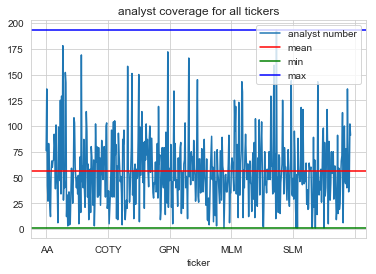

In [98]:
ax1 = df_1.plot(use_index=True, title='analyst coverage for all tickers')
ax1.axhline(df_1.mean()[0], c='r')
ax1.axhline(df_1.min()[0], c='g')
ax1.axhline(df_1.max()[0], c='b')
ax1.legend(["analyst number", "mean",'min','max'])

In [99]:
# each ticker and each fpedats - analyst coverage
df_2 = df_short.reset_index().groupby(by=['ticker','fpedats'])['analys'].nunique().to_frame()
df_2

analys
ticker fpedats           
AA     2003-12-31      24
       2004-12-31      22
       2005-12-31      22
       2006-12-31      25
       2007-12-31      20
...                   ...
ZMH    2016-12-31      30
       2017-12-31      27
       2018-12-31      33
       2019-12-31      30
       2020-12-31      29

[6566 rows x 1 columns]

In [100]:
AMD_df_2 = df_2.loc['AMD',]
AMD_df_2

,analys
fpedats,
2003-12-31,41
2004-12-31,36
2005-12-31,40
2006-12-31,39
2007-12-31,39
2008-12-31,32
2009-12-31,35
2010-12-31,36
2011-12-31,41


In [101]:
AMD_df_2.describe()

,analys
count,18.000000
mean,36.000000
std,2.930569
min,32.000000
25%,34.000000
50%,35.500000
75%,38.500000
max,41.000000


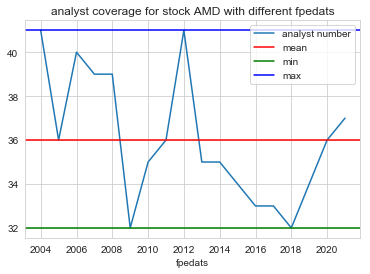

In [102]:
ax2 = AMD_df_2.plot(use_index=True, title='analyst coverage for stock AMD with different fpedats')
ax2.axhline(AMD_df_2.mean()[0], c='r')
ax2.axhline(AMD_df_2.min()[0], c='g')
ax2.axhline(AMD_df_2.max()[0], c='b')
ax2.legend(["analyst number", "mean",'min','max'])

In [103]:
# summary statistics
forecast_df.describe()

,analys,estimator,value,actual
count,4.451485e+06,4.451485e+06,4.451485e+06,4.451485e+06
mean,8.574442e+04,1.014837e+03,2.098705e+00,1.912052e+00
std,4.570528e+04,1.151498e+03,4.398751e+00,5.298103e+00
min,0.000000e+00,3.000000e+00,-1.280000e+02,-3.982000e+02
25%,5.311200e+04,1.570000e+02,4.700000e-01,4.300000e-01
50%,8.310900e+04,2.820000e+02,1.050000e+00,1.010000e+00
75%,1.181140e+05,1.872000e+03,2.415000e+00,2.320000e+00
max,1.967120e+05,4.510000e+03,3.813600e+02,1.176000e+02


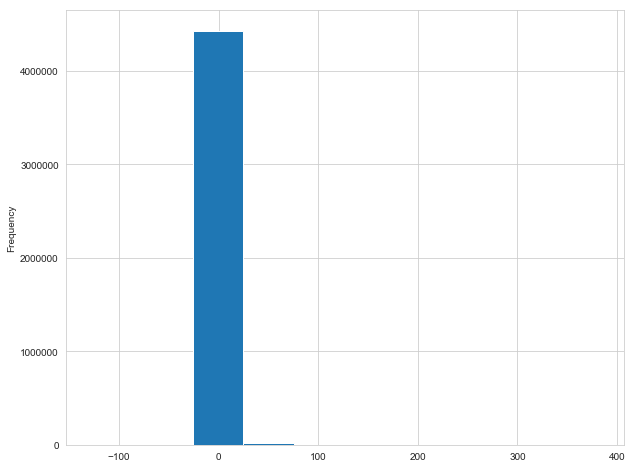

In [104]:
forecast_df['value'].plot.hist(figsize=(10, 8))

Text(0, 0.5, 'Number of estimates')

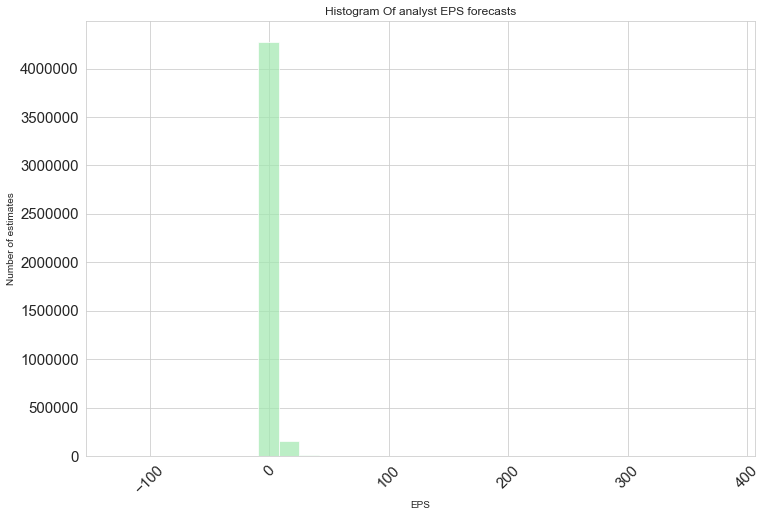

In [105]:
forecast_df['value'].plot(kind='hist',
        alpha=0.7,
        bins=30,
        title='Histogram Of analyst EPS forecasts',
        rot=45,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF'])
plt.xlabel('EPS')
plt.ylabel("Number of estimates")

### Compare earnings announcement dates and analyst announcement dates

**Difference Between IBES Earnings Announcement Date and Compustat Announcement Dates**

Detail
The announcement date is the release date of information to the market. IBES has two variables related to the timing of earnings announcements: **ANNDATS** and **ACTDATS**. The former refers to the time when the company announced earnings (according to the business newswires), whereas the latter refers to the date when the information was entered into the IBES database.

On the other hand, Compustat has a report date of quarterly earning which is available only in Compustat quarterly data (variable is RDQ and its definition by Compustat is "This descriptor represents the date in which quarterly earnings and earnings per share figures are first publicly reported in the various news media.").

In most cases ANNDATS and RDQ are the same.  A Paper by Livnat and Mendenhall (JAR, 2006) "Comparing the Post-Earnings Announcement Drift for Surprises Calculated from Analyst and Time Series Forecasts" provides a nice discussion of the differences between Compustat and IBES data. 

In [20]:
parm = {'tickers': tic_list, 'start_date' : start_date, 'end_date': end_date}

QEA_df = conn.raw_sql(f"""
                             select ticker, cusip, pends, anndats, actdats, value from ibes.act_epsus
                             where ticker in %(tickers)s and cusip != '' and pends >= %(start_date)s and pends < %(end_date)s
                            """, params=parm)

In [21]:
parm = {'tickers': tic_list, 'start_date' : start_date, 'end_date': end_date}
comp_df = conn.raw_sql(f"""
                             select tic, cusip, conm, APDEDATEQ, FDATEQ, PDATEQ, EPSFXQ from comp.fundq
                             where tic in %(tickers)s and APDEDATEQ >= %(start_date)s and APDEDATEQ < %(end_date)s
                            """,
                       params=parm)

In [22]:
comp_df = comp_df.dropna().reset_index(drop = True)
comp_df

,tic,cusip,conm,apdedateq,fdateq,pdateq,epsfxq
0,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2006-09-30,2006-10-23,2006-10-18,0.06
1,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2006-12-31,2007-03-10,2007-01-17,0.07
2,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2007-03-31,2007-05-31,2007-04-20,0.30
3,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2016-12-31,2017-02-26,2017-01-27,0.56
4,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2007-06-30,2007-08-07,2007-07-18,1.08
...,...,...,...,...,...,...,...
32977,NVT,G6700G107,NVENT ELECTRIC PLC,2019-06-30,2019-08-12,2019-08-01,0.35
32978,NVT,G6700G107,NVENT ELECTRIC PLC,2019-09-30,2019-11-04,2019-10-30,0.35
32979,NVT,G6700G107,NVENT ELECTRIC PLC,2019-12-31,2020-03-06,2020-02-05,0.27
32980,NVT,G6700G107,NVENT ELECTRIC PLC,2020-03-31,2020-04-30,2020-04-29,0.11


In [23]:
QEA_df = QEA_df.dropna().reset_index(drop = True)
QEA_df

,ticker,cusip,pends,anndats,actdats,value
0,AA,01381710,2003-03-31,2003-04-04,2003-04-04,0.69
1,AA,01381710,2003-06-30,2003-07-08,2003-07-08,0.81
2,AA,01381710,2003-09-30,2003-10-07,2003-10-07,0.99
3,AA,01381710,2003-12-31,2004-01-08,2004-01-08,3.30
4,AA,01381710,2003-12-31,2004-01-08,2004-01-08,0.81
...,...,...,...,...,...,...
37922,ZMH,98956P10,2019-09-30,2019-11-05,2019-11-05,1.77
37923,ZMH,98956P10,2019-12-31,2020-02-04,2020-02-04,7.87
37924,ZMH,98956P10,2019-12-31,2020-02-04,2020-02-04,2.30
37925,ZMH,98956P10,2020-03-31,2020-05-11,2020-05-11,1.70


In [24]:
# earnings announcement data for AMD
AMD_df = QEA_df[QEA_df["ticker"]=='AMD']
AMD_df

,ticker,cusip,pends,anndats,actdats,value
1973,AMD,00790310,2003-03-31,2003-04-16,2003-04-16,-0.42
1974,AMD,00790310,2003-06-30,2003-07-16,2003-07-16,-0.40
1975,AMD,00790310,2003-09-30,2003-10-16,2003-10-17,-0.09
1976,AMD,00790310,2003-12-31,2004-01-20,2004-01-21,-0.79
1977,AMD,00790310,2003-12-31,2004-01-20,2004-01-21,0.12
...,...,...,...,...,...,...
2055,AMD,00790310,2019-09-30,2019-10-29,2019-10-29,0.18
2056,AMD,00790310,2019-12-31,2020-01-28,2020-01-28,0.64
2057,AMD,00790310,2019-12-31,2020-01-28,2020-01-28,0.32
2058,AMD,00790310,2020-03-31,2020-04-28,2020-04-28,0.18


In [25]:
# analyst forecast data for AMD stock
AMD_af = df_short1.loc[('AMD',81219.0)]
AMD_af['year_end'] = [int(x.month==12) for x in AMD_af['fpedats']]
AMD_af

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


cusip  estimator  value measure     anndats     actdats  \
ticker analys                                                                
AMD    81219.0  00790310      899.0  -0.52     EPS  2003-01-17  2003-01-18   
       81219.0  00790310      899.0  -0.47     EPS  2003-03-07  2003-03-07   
       81219.0  00790310      899.0  -0.43     EPS  2003-01-13  2003-01-13   
       81219.0  00790310      899.0  -0.28     EPS  2003-04-17  2003-04-17   
       81219.0  00790310      899.0  -0.61     EPS  2003-06-25  2003-06-25   
...                  ...        ...    ...     ...         ...         ...   
       81219.0  00790310      171.0   0.12     EPS  2018-07-25  2018-07-25   
       81219.0  00790310      171.0   0.10     EPS  2018-01-31  2018-01-31   
       81219.0  00790310      171.0   0.12     EPS  2018-07-25  2018-07-25   
       81219.0  00790310      171.0   0.10     EPS  2018-04-25  2018-04-25   
       81219.0  00790310      171.0   0.15     EPS  2018-07-25  2018-07-25   

               anndats_act     fpedats  actual fpi  year_end  
ticker analys                                                 
AMD    81219.0  2003-04-16  2003-03-31   -0.42   6         0  
       81219.0  2003-04-16  2003-03-31   -0.42   6         0  
       81219.0  2003-04-16  2003-03-31   -0.42   7         0  
       81219.0  2003-07-16  2003-06-30   -0.40   6         0  
       81219.0  2003-07-16  2003-06-30   -0.40   6         0  
...                    ...         ...     ...  ..       ...  
       81219.0  2019-01-29  2018-12-31    0.08   7         1  
       81219.0  2019-01-29  2018-12-31    0.08   9         1  
       81219.0  2019-04-30  2019-03-31    0.06   8         0  
       81219.0  2019-04-30  2019-03-31    0.06   9         0  
       81219.0  2019-07-30  2019-06-30    0.08   9         0  

[520 rows x 11 columns]

In [26]:
# summary statistics of fpedats ending in December 31
AMD_af['year_end'].mean()

0.40384615384615385

In [27]:
AMD_af.set_index(['fpedats'],inplace=True)
AMD_af.sort_index(inplace=True)
AMD_af.sort_values(by=['fpedats','anndats'],inplace=True)
AMD_af


/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cusip,estimator,value,measure,anndats,actdats,anndats_act,actual,fpi,year_end
fpedats,,,,,,,,,,
2003-03-31,00790310,899.0,-0.43,EPS,2003-01-13,2003-01-13,2003-04-16,-0.42,7,0
2003-03-31,00790310,899.0,-0.52,EPS,2003-01-17,2003-01-18,2003-04-16,-0.42,6,0
2003-03-31,00790310,899.0,-0.47,EPS,2003-03-07,2003-03-07,2003-04-16,-0.42,6,0
2003-06-30,00790310,899.0,-0.27,EPS,2003-01-13,2003-01-13,2003-07-16,-0.40,8,0
2003-06-30,00790310,899.0,-0.45,EPS,2003-01-17,2003-01-18,2003-07-16,-0.40,7,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,00790310,171.0,0.51,EPS,2018-07-25,2018-07-25,2019-01-29,0.46,1,1
2018-12-31,00790310,171.0,0.12,EPS,2018-07-25,2018-07-25,2019-01-29,0.08,7,1
2019-03-31,00790310,171.0,0.10,EPS,2018-04-25,2018-04-25,2019-04-30,0.06,9,0


In [28]:
dec_AMD_af = AMD_af[AMD_af['year_end']==1]
dec_AMD_af

,cusip,estimator,value,measure,anndats,actdats,anndats_act,actual,fpi,year_end
fpedats,,,,,,,,,,
2003-12-31,00790310,899.0,-0.78,EPS,2003-01-13,2003-01-13,2004-01-20,-0.79,2,1
2003-12-31,00790310,899.0,-1.18,EPS,2003-01-17,2003-01-18,2004-01-20,-0.79,1,1
2003-12-31,00790310,899.0,0.00,EPS,2003-01-17,2003-01-18,2004-01-20,0.12,9,1
2003-12-31,00790310,899.0,-1.00,EPS,2003-03-07,2003-03-07,2004-01-20,-0.79,1,1
2003-12-31,00790310,899.0,0.01,EPS,2003-03-07,2003-03-07,2004-01-20,0.12,9,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,00790310,171.0,0.40,EPS,2018-01-31,2018-01-31,2019-01-29,0.46,1,1
2018-12-31,00790310,171.0,0.10,EPS,2018-01-31,2018-01-31,2019-01-29,0.08,9,1
2018-12-31,00790310,171.0,0.48,EPS,2018-04-25,2018-04-25,2019-01-29,0.46,1,1


In [29]:
# keep only the first data of two identical rows
dec_AMD_af = dec_AMD_af.drop_duplicates(subset=['anndats', 'anndats_act'], keep='first')

In [30]:
# calculate analyst forecast revisions
dec_AMD_af['forecast_revision'] = dec_AMD_af.groupby(['fpedats'])['value'].transform(lambda x: x.diff()) 

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
dec_AMD_af

,cusip,estimator,value,measure,anndats,actdats,anndats_act,actual,fpi,year_end,forecast_revision
fpedats,,,,,,,,,,,
2003-12-31,00790310,899.0,-0.78,EPS,2003-01-13,2003-01-13,2004-01-20,-0.79,2,1,NaN
2003-12-31,00790310,899.0,-1.18,EPS,2003-01-17,2003-01-18,2004-01-20,-0.79,1,1,-0.40
2003-12-31,00790310,899.0,-1.00,EPS,2003-03-07,2003-03-07,2004-01-20,-0.79,1,1,0.18
2003-12-31,00790310,899.0,-0.80,EPS,2003-04-14,2003-04-14,2004-01-20,-0.79,1,1,0.20
2003-12-31,00790310,899.0,-0.79,EPS,2003-04-17,2003-04-17,2004-01-20,-0.79,1,1,0.01
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,00790310,171.0,0.10,EPS,2017-07-25,2017-07-25,2018-01-30,0.17,1,1,-0.03
2017-12-31,00790310,171.0,0.14,EPS,2017-10-24,2017-10-24,2018-01-30,0.17,1,1,0.04
2018-12-31,00790310,171.0,0.40,EPS,2018-01-31,2018-01-31,2019-01-29,0.46,1,1,NaN


In [32]:
dec_AMD_af.reset_index(inplace=True)
dec_AMD_af['year']=[x.year for x in dec_AMD_af['anndats']]
dec_AMD_af.set_index(['anndats'],inplace=True)
dec_AMD_af

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,fpedats,cusip,estimator,value,measure,actdats,anndats_act,actual,fpi,year_end,forecast_revision,year
anndats,,,,,,,,,,,,
2003-01-13,2003-12-31,00790310,899.0,-0.78,EPS,2003-01-13,2004-01-20,-0.79,2,1,NaN,2003
2003-01-17,2003-12-31,00790310,899.0,-1.18,EPS,2003-01-18,2004-01-20,-0.79,1,1,-0.40,2003
2003-03-07,2003-12-31,00790310,899.0,-1.00,EPS,2003-03-07,2004-01-20,-0.79,1,1,0.18,2003
2003-04-14,2003-12-31,00790310,899.0,-0.80,EPS,2003-04-14,2004-01-20,-0.79,1,1,0.20,2003
2003-04-17,2003-12-31,00790310,899.0,-0.79,EPS,2003-04-17,2004-01-20,-0.79,1,1,0.01,2003
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-25,2017-12-31,00790310,171.0,0.10,EPS,2017-07-25,2018-01-30,0.17,1,1,-0.03,2017
2017-10-24,2017-12-31,00790310,171.0,0.14,EPS,2017-10-24,2018-01-30,0.17,1,1,0.04,2017
2018-01-31,2018-12-31,00790310,171.0,0.40,EPS,2018-01-31,2019-01-29,0.46,1,1,NaN,2018


In [33]:
# summary of upward&downward revision
upward_ar = dec_AMD_af.loc[dec_AMD_af['forecast_revision'] > 0,'value'].count()
downward_ar = dec_AMD_af.loc[dec_AMD_af['forecast_revision'] < 0,'value'].count()
print(f'ratio of upward revision is {upward_ar/(upward_ar+downward_ar)}')

ratio of upward revision is 0.4946236559139785


In [34]:
import os
directory_in_str = '/Users/chentian/Desktop/RAdata/text_data'

directory = os.fsencode(directory_in_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        print(os.path.join(directory_in_str, filename))

/Users/chentian/Desktop/RAdata/text_data/2017-04_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-05_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-07_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-06_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-03_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-12_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-02_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-10_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-09_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-08_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-11_all.pkl
/Users/chentian/Desktop/RAdata/text_data/2017-01_all.pkl


In [35]:
# Let's focus on data of year 2017 first
AMD_2017_af=dec_AMD_af[dec_AMD_af['year']==2017]
AMD_2017_af

,fpedats,cusip,estimator,value,measure,actdats,anndats_act,actual,fpi,year_end,forecast_revision,year
anndats,,,,,,,,,,,,
2017-01-31,2017-12-31,00790310,899.0,0.06,EPS,2017-02-01,2018-01-30,0.17,1,1,NaN,2017
2017-04-04,2017-12-31,00790310,899.0,0.11,EPS,2017-04-05,2018-01-30,0.17,1,1,0.05,2017
2017-05-01,2017-12-31,00790310,899.0,0.12,EPS,2017-05-02,2018-01-30,0.17,1,1,0.01,2017
2017-06-20,2017-12-31,00790310,899.0,0.13,EPS,2017-06-20,2018-01-30,0.17,1,1,0.01,2017
2017-06-30,2017-12-31,00790310,171.0,0.13,EPS,2017-06-30,2018-01-30,0.17,1,1,0.00,2017
2017-07-25,2017-12-31,00790310,171.0,0.10,EPS,2017-07-25,2018-01-30,0.17,1,1,-0.03,2017
2017-10-24,2017-12-31,00790310,171.0,0.14,EPS,2017-10-24,2018-01-30,0.17,1,1,0.04,2017


In [38]:
# set target days - one day before the ann_dates
dates_dic = { date : (date - datetime.timedelta(days=1)) for date in AMD_2017_af.index}
#target_dates = list(AMD_2017_af.index - datetime.timedelta(days=1))
dates_dic

{datetime.date(2017, 1, 31): datetime.date(2017, 1, 30),
 datetime.date(2017, 4, 4): datetime.date(2017, 4, 3),
 datetime.date(2017, 5, 1): datetime.date(2017, 4, 30),
 datetime.date(2017, 6, 20): datetime.date(2017, 6, 19),
 datetime.date(2017, 6, 30): datetime.date(2017, 6, 29),
 datetime.date(2017, 7, 25): datetime.date(2017, 7, 24),
 datetime.date(2017, 10, 24): datetime.date(2017, 10, 23)}

In [40]:
import os
text_data1 = pd.DataFrame()
directory_in_str = '/Users/chentian/Desktop/RAdata/text_data'
format='%Y%m%d'
directory = os.fsencode(directory_in_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        file_path = os.path.join(directory_in_str, filename)
        data1 = pd.read_pickle(file_path)
        # convert from string format to datetime format
        data1['Date']=data1['Date'].apply(lambda x: datetime.datetime.strptime(x, format).date())
        #data1['Date'] = pd.to_datetime(data1['Date'], format='%Y%m%d')
        #data1.set_index(['Date'],inplace=True)
        for key, value in dates_dic.items():
            data2 = data1[data1['Date']==value]
            data2['anndats'] = key
            text_data1 = pd.concat([text_data1,data2])
            #text_data1 = pd.concat([text_data1,data1[data1.Date.isin(dates_dic.values)]])
        
text_data1.sort_values(by=['Date'],inplace=True)
text_data1.reset_index(drop=True,inplace=True)

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [41]:
# match news data with analyst forecast data using anndats
text_data1

,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,anndats
0,2017-01-30,\nUKDAY\n,\nEuropean Morning Briefing: Dividend Payment ...,\n\n Alantra Partners SA (ALNT.MC)Special div...,20170131T045448.772Z,"January 30, 2017 23:54 ET (04:54 GMT)",20170130013537,2017-01-31
1,2017-01-30,\nRSSS\n,\nPress Release: Reprints Desk Taps Sharon Mat...,\n\n Reprints Desk Taps Sharon Mattern Büttik...,20170130T140102.700Z,"January 30, 2017 09:01 ET (14:01 GMT)",20170130005363,2017-01-31
2,2017-01-30,None,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140000.000Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005356,2017-01-31
3,2017-01-30,\nAAL\nDAL\nJBLU\nLUV\n,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140057.409Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005355,2017-01-31
4,2017-01-30,\nIMMU\n,\nVenBio Owns 9.9% of Immunomedics,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170130T140048.623Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005270,2017-01-31
...,...,...,...,...,...,...,...,...
27853,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23,\n\nContracts for Nov 2017 through Dec 2017 wi...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24
27854,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23 -2-,\n\nOH 12 2017 C 1.74 0.0866 0.0692 ...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24
27855,2017-10-23,\nPHOT\n,"\nDir Fasci Buys 250,000 Of GrowLife Inc >PHOT...",\n\n \nSOURCE: Form 4/A (Amended Filing) \n \n...,20171023T144104.124Z,"October 23, 2017 10:41 ET (14:41 GMT)",20171023006424,2017-10-24
27856,2017-10-23,\nTIME\n,\nTime Price Target Cut to $13.00/Share From $...,\n\n \n\n Ratings actions from Benzinga: http...,20171023T144455.460Z,"October 23, 2017 10:44 ET (14:44 GMT)",20171023006456,2017-10-24


### Sentiment analysis using all the news before the announcement days

In [42]:
import numpy as np
import pandas

import collections
import random

import spacy

try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

def spacy_pos(word_list, model=nlp):
    tags = []
    # spacy expects a string to start doing the pos-tagging so we convert a list to a string
    if type(word_list) == list:
        word_list = ' '.join(word_list)
    doc = model(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

def tag_sents_pos(sentences, model=nlp):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    
    doc = model(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

def tag_sents_ner(sentences, model=nlp):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = model(final_string)
    
    ner_sents = []
    for sent in doc.sents:
        ner_sent = []
        for ent in sent.ents:
            ner_sent.append((ent.text, ent.label_))
        ner_sents.append(pos_sent)
    
    return ner_sents

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def sent_tokenize(word_list, model=nlp):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def count_words(traingDF, textColumn, trainingColumn):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in set(row[textColumn]):
            if row[trainingColumn]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts

def trainTestSplit(df, holdBackFraction = .2):
    df = df.reindex(np.random.permutation(df.index))
    holdBackIndex = int(holdBackFraction * len(df))
    train_data = df[holdBackIndex:].copy()
    test_data = df[:holdBackIndex].copy()

    return train_data, test_data

In [ ]:
!pip install textblob

In [43]:
text_data1['tokenized_title'] = text_data1['Title'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
text_data1['normalized_title'] = text_data1['tokenized_title'].apply(lambda x: [normalizeTokens(s, lemma=True, extra_stop=['|','$','+','=','sa','gmt']) for s in x])

In [44]:
text_data1

,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,anndats,tokenized_title,normalized_title
0,2017-01-30,\nUKDAY\n,\nEuropean Morning Briefing: Dividend Payment ...,\n\n Alantra Partners SA (ALNT.MC)Special div...,20170131T045448.772Z,"January 30, 2017 23:54 ET (04:54 GMT)",20170130013537,2017-01-31,"[[European, Morning, Briefing], [Dividend, Pay...","[[european, morning, brief], [dividend, paymen..."
1,2017-01-30,\nRSSS\n,\nPress Release: Reprints Desk Taps Sharon Mat...,\n\n Reprints Desk Taps Sharon Mattern Büttik...,20170130T140102.700Z,"January 30, 2017 09:01 ET (14:01 GMT)",20170130005363,2017-01-31,"[[Press, Release], [Reprints], [Desk, Taps, Sh...","[[press, release], [reprint], [desk, tap, shar..."
2,2017-01-30,None,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140000.000Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005356,2017-01-31,"[[Airlines, Slide], [After, Immigration, Order...","[[airline, slide], [immigration, order, trump,..."
3,2017-01-30,\nAAL\nDAL\nJBLU\nLUV\n,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140057.409Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005355,2017-01-31,"[[Airlines, Slide], [After, Immigration, Order...","[[airline, slide], [immigration, order, trump,..."
4,2017-01-30,\nIMMU\n,\nVenBio Owns 9.9% of Immunomedics,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170130T140048.623Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005270,2017-01-31,"[[VenBio, Owns, 9.9, of, Immunomedics]]","[[venbio, own, immunomedics]]"
...,...,...,...,...,...,...,...,...,...,...
27853,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23,\n\nContracts for Nov 2017 through Dec 2017 wi...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24,"[[Nymex, Harbor, ULSD, Options, Close, Oct, 23]]","[[nymex, harbor, ulsd, option, close, oct]]"
27854,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23 -2-,\n\nOH 12 2017 C 1.74 0.0866 0.0692 ...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24,"[[Nymex, Harbor, ULSD, Options, Close, Oct, 23...","[[nymex, harbor, ulsd, option, close, oct, -2-]]"
27855,2017-10-23,\nPHOT\n,"\nDir Fasci Buys 250,000 Of GrowLife Inc >PHOT...",\n\n \nSOURCE: Form 4/A (Amended Filing) \n \n...,20171023T144104.124Z,"October 23, 2017 10:41 ET (14:41 GMT)",20171023006424,2017-10-24,"[[Dir, Fasci, Buys, 250,000, Of, GrowLife, Inc...","[[dir, fasci, buy, growlife, inc, >, phot, ame..."
27856,2017-10-23,\nTIME\n,\nTime Price Target Cut to $13.00/Share From $...,\n\n \n\n Ratings actions from Benzinga: http...,20171023T144455.460Z,"October 23, 2017 10:44 ET (14:44 GMT)",20171023006456,2017-10-24,"[[Time, Price, Target, Cut, to, $, 13.00/Share...","[[time, price, target, cut, 13.00/share, morga..."


In [45]:
from textblob import TextBlob
testimonial =TextBlob(text_data1['Article'][10])
testimonial.sentiment.polarity
text_data1['title_sent']=text_data1['Title'].transform(lambda x: TextBlob(x).sentiment.polarity)
text_data1['article_sent']=text_data1['Article'].transform(lambda x: TextBlob(x).sentiment.polarity)

In [46]:
text_data1['article_sent'].describe()

count    27858.000000
mean         0.138761
std          0.197701
min         -0.800000
25%          0.010242
50%          0.065486
75%          0.177705
max          0.800000
Name: article_sent, dtype: float64

In [47]:
text_data1

,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,anndats,tokenized_title,normalized_title,title_sent,article_sent
0,2017-01-30,\nUKDAY\n,\nEuropean Morning Briefing: Dividend Payment ...,\n\n Alantra Partners SA (ALNT.MC)Special div...,20170131T045448.772Z,"January 30, 2017 23:54 ET (04:54 GMT)",20170130013537,2017-01-31,"[[European, Morning, Briefing], [Dividend, Pay...","[[european, morning, brief], [dividend, paymen...",0.00,0.000000
1,2017-01-30,\nRSSS\n,\nPress Release: Reprints Desk Taps Sharon Mat...,\n\n Reprints Desk Taps Sharon Mattern Büttik...,20170130T140102.700Z,"January 30, 2017 09:01 ET (14:01 GMT)",20170130005363,2017-01-31,"[[Press, Release], [Reprints], [Desk, Taps, Sh...","[[press, release], [reprint], [desk, tap, shar...",0.00,0.131902
2,2017-01-30,None,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140000.000Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005356,2017-01-31,"[[Airlines, Slide], [After, Immigration, Order...","[[airline, slide], [immigration, order, trump,...",0.00,0.106973
3,2017-01-30,\nAAL\nDAL\nJBLU\nLUV\n,"\nAirlines Slide After Immigration Orders, Tru...",\n\n 9:00 ET - Shares of airlines are falling...,20170130T140057.409Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005355,2017-01-31,"[[Airlines, Slide], [After, Immigration, Order...","[[airline, slide], [immigration, order, trump,...",0.00,-0.006173
4,2017-01-30,\nIMMU\n,\nVenBio Owns 9.9% of Immunomedics,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170130T140048.623Z,"January 30, 2017 09:00 ET (14:00 GMT)",20170130005270,2017-01-31,"[[VenBio, Owns, 9.9, of, Immunomedics]]","[[venbio, own, immunomedics]]",0.00,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
27853,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23,\n\nContracts for Nov 2017 through Dec 2017 wi...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24,"[[Nymex, Harbor, ULSD, Options, Close, Oct, 23]]","[[nymex, harbor, ulsd, option, close, oct]]",0.00,0.016000
27854,2017-10-23,None,\nNymex Harbor ULSD Options Close - Oct 23 -2-,\n\nOH 12 2017 C 1.74 0.0866 0.0692 ...,20171023T144037.359Z,"October 23, 2017 10:40 ET (14:40 GMT)",20171023006421,2017-10-24,"[[Nymex, Harbor, ULSD, Options, Close, Oct, 23...","[[nymex, harbor, ulsd, option, close, oct, -2-]]",0.00,0.000000
27855,2017-10-23,\nPHOT\n,"\nDir Fasci Buys 250,000 Of GrowLife Inc >PHOT...",\n\n \nSOURCE: Form 4/A (Amended Filing) \n \n...,20171023T144104.124Z,"October 23, 2017 10:41 ET (14:41 GMT)",20171023006424,2017-10-24,"[[Dir, Fasci, Buys, 250,000, Of, GrowLife, Inc...","[[dir, fasci, buy, growlife, inc, >, phot, ame...",0.00,0.050000
27856,2017-10-23,\nTIME\n,\nTime Price Target Cut to $13.00/Share From $...,\n\n \n\n Ratings actions from Benzinga: http...,20171023T144455.460Z,"October 23, 2017 10:44 ET (14:44 GMT)",20171023006456,2017-10-24,"[[Time, Price, Target, Cut, to, $, 13.00/Share...","[[time, price, target, cut, 13.00/share, morga...",0.00,0.000000


In [48]:
text_data1.set_index(['anndats', 'Date'],inplace=True)
text_data1

Company  \
anndats    Date                                  
2017-01-31 2017-01-30                \nUKDAY\n   
           2017-01-30                 \nRSSS\n   
           2017-01-30                     None   
           2017-01-30  \nAAL\nDAL\nJBLU\nLUV\n   
           2017-01-30                 \nIMMU\n   
...                                        ...   
2017-10-24 2017-10-23                     None   
           2017-10-23                     None   
           2017-10-23                 \nPHOT\n   
           2017-10-23                 \nTIME\n   
           2017-10-23                     None   

                                                                   Title  \
anndats    Date                                                            
2017-01-31 2017-01-30  \nEuropean Morning Briefing: Dividend Payment ...   
           2017-01-30  \nPress Release: Reprints Desk Taps Sharon Mat...   
           2017-01-30  \nAirlines Slide After Immigration Orders, Tru...   
           2017-01-30  \nAirlines Slide After Immigration Orders, Tru...   
           2017-01-30                 \nVenBio Owns 9.9% of Immunomedics   
...                                                                  ...   
2017-10-24 2017-10-23         \nNymex Harbor ULSD Options Close - Oct 23   
           2017-10-23     \nNymex Harbor ULSD Options Close - Oct 23 -2-   
           2017-10-23  \nDir Fasci Buys 250,000 Of GrowLife Inc >PHOT...   
           2017-10-23  \nTime Price Target Cut to $13.00/Share From $...   
           2017-10-23         \nUS 6-Month Bills: 1.245%; 51.38% At High   

                                                                 Article  \
anndats    Date                                                            
2017-01-31 2017-01-30  \n\n  Alantra Partners SA (ALNT.MC)Special div...   
           2017-01-30  \n\n  Reprints Desk Taps Sharon Mattern Büttik...   
           2017-01-30  \n\n  9:00 ET - Shares of airlines are falling...   
           2017-01-30  \n\n  9:00 ET - Shares of airlines are falling...   
           2017-01-30  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
...                                                                  ...   
2017-10-24 2017-10-23  \n\nContracts for Nov 2017 through Dec 2017 wi...   
           2017-10-23  \n\nOH   12  2017 C   1.74  0.0866  0.0692    ...   
           2017-10-23  \n\n \nSOURCE: Form 4/A (Amended Filing) \n \n...   
           2017-10-23  \n\n \n\n  Ratings actions from Benzinga: http...   
           2017-10-23  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   

                            System_GMT_Time  \
anndats    Date                               
2017-01-31 2017-01-30  20170131T045448.772Z   
           2017-01-30  20170130T140102.700Z   
           2017-01-30  20170130T140000.000Z   
           2017-01-30  20170130T140057.409Z   
           2017-01-30  20170130T140048.623Z   
...                                     ...   
2017-10-24 2017-10-23  20171023T144037.359Z   
           2017-10-23  20171023T144037.359Z   
           2017-10-23  20171023T144104.124Z   
           2017-10-23  20171023T144455.460Z   
           2017-10-23  20171023T153150.364Z   

                                             Display_ET_Time Accession_Number  \
anndats    Date                                                                 
2017-01-31 2017-01-30  January 30, 2017 23:54 ET (04:54 GMT)   20170130013537   
           2017-01-30  January 30, 2017 09:01 ET (14:01 GMT)   20170130005363   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005356   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005355   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005270   
...                                                      ...              ...   
2017-10-24 2017-10-23  October 23, 2017 10:40 ET (14:40 GMT)   20171023006421   
           2017-10-23  October 23, 2017 10:40 ET (14:40 GMT)   201710

In [115]:
text_data1

Company  \
anndats    Date                                  
2017-01-31 2017-01-30                \nUKDAY\n   
           2017-01-30                 \nRSSS\n   
           2017-01-30                     None   
           2017-01-30  \nAAL\nDAL\nJBLU\nLUV\n   
           2017-01-30                 \nIMMU\n   
...                                        ...   
2017-10-24 2017-10-23                     None   
           2017-10-23                     None   
           2017-10-23                 \nPHOT\n   
           2017-10-23                 \nTIME\n   
           2017-10-23                     None   

                                                                   Title  \
anndats    Date                                                            
2017-01-31 2017-01-30  \nEuropean Morning Briefing: Dividend Payment ...   
           2017-01-30  \nPress Release: Reprints Desk Taps Sharon Mat...   
           2017-01-30  \nAirlines Slide After Immigration Orders, Tru...   
           2017-01-30  \nAirlines Slide After Immigration Orders, Tru...   
           2017-01-30                 \nVenBio Owns 9.9% of Immunomedics   
...                                                                  ...   
2017-10-24 2017-10-23         \nNymex Harbor ULSD Options Close - Oct 23   
           2017-10-23     \nNymex Harbor ULSD Options Close - Oct 23 -2-   
           2017-10-23  \nDir Fasci Buys 250,000 Of GrowLife Inc >PHOT...   
           2017-10-23  \nTime Price Target Cut to $13.00/Share From $...   
           2017-10-23         \nUS 6-Month Bills: 1.245%; 51.38% At High   

                                                                 Article  \
anndats    Date                                                            
2017-01-31 2017-01-30  \n\n  Alantra Partners SA (ALNT.MC)Special div...   
           2017-01-30  \n\n  Reprints Desk Taps Sharon Mattern Büttik...   
           2017-01-30  \n\n  9:00 ET - Shares of airlines are falling...   
           2017-01-30  \n\n  9:00 ET - Shares of airlines are falling...   
           2017-01-30  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
...                                                                  ...   
2017-10-24 2017-10-23  \n\nContracts for Nov 2017 through Dec 2017 wi...   
           2017-10-23  \n\nOH   12  2017 C   1.74  0.0866  0.0692    ...   
           2017-10-23  \n\n \nSOURCE: Form 4/A (Amended Filing) \n \n...   
           2017-10-23  \n\n \n\n  Ratings actions from Benzinga: http...   
           2017-10-23  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   

                            System_GMT_Time  \
anndats    Date                               
2017-01-31 2017-01-30  20170131T045448.772Z   
           2017-01-30  20170130T140102.700Z   
           2017-01-30  20170130T140000.000Z   
           2017-01-30  20170130T140057.409Z   
           2017-01-30  20170130T140048.623Z   
...                                     ...   
2017-10-24 2017-10-23  20171023T144037.359Z   
           2017-10-23  20171023T144037.359Z   
           2017-10-23  20171023T144104.124Z   
           2017-10-23  20171023T144455.460Z   
           2017-10-23  20171023T153150.364Z   

                                             Display_ET_Time Accession_Number  \
anndats    Date                                                                 
2017-01-31 2017-01-30  January 30, 2017 23:54 ET (04:54 GMT)   20170130013537   
           2017-01-30  January 30, 2017 09:01 ET (14:01 GMT)   20170130005363   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005356   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005355   
           2017-01-30  January 30, 2017 09:00 ET (14:00 GMT)   20170130005270   
...                                                      ...              ...   
2017-10-24 2017-10-23  October 23, 2017 10:40 ET (14:40 GMT)   20171023006421   
           2017-10-23  October 23, 2017 10:40 ET (14:40 GMT)   201710

In [116]:
agg_sent_2017 = text_data1.groupby(level=0)['title_sent','article_sent'].mean()

/Users/chentian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [117]:
agg_sent_2017

,title_sent,article_sent
anndats,,
2017-01-31,0.021191,0.160785
2017-04-04,0.032177,0.150583
2017-05-01,0.017707,0.078355
2017-06-20,0.037668,0.155582
2017-06-30,0.029221,0.149905
2017-07-25,0.016011,0.124888
2017-10-24,0.022541,0.115654


In [119]:
AMD_2017_af = AMD_2017_af.join(agg_sent_2017)
AMD_2017_af

,fpedats,cusip,estimator,value,measure,actdats,anndats_act,actual,fpi,year_end,forecast_revision,year,title_sent,article_sent
anndats,,,,,,,,,,,,,,
2017-01-31,2017-12-31,00790310,899.0,0.06,EPS,2017-02-01,2018-01-30,0.17,1,1,NaN,2017,0.021191,0.160785
2017-04-04,2017-12-31,00790310,899.0,0.11,EPS,2017-04-05,2018-01-30,0.17,1,1,0.05,2017,0.032177,0.150583
2017-05-01,2017-12-31,00790310,899.0,0.12,EPS,2017-05-02,2018-01-30,0.17,1,1,0.01,2017,0.017707,0.078355
2017-06-20,2017-12-31,00790310,899.0,0.13,EPS,2017-06-20,2018-01-30,0.17,1,1,0.01,2017,0.037668,0.155582
2017-06-30,2017-12-31,00790310,171.0,0.13,EPS,2017-06-30,2018-01-30,0.17,1,1,0.00,2017,0.029221,0.149905
2017-07-25,2017-12-31,00790310,171.0,0.10,EPS,2017-07-25,2018-01-30,0.17,1,1,-0.03,2017,0.016011,0.124888
2017-10-24,2017-12-31,00790310,171.0,0.14,EPS,2017-10-24,2018-01-30,0.17,1,1,0.04,2017,0.022541,0.115654
